In [25]:
# quandly for financial data
import quandl
# pandas for data manipulation
import pandas as pd
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [26]:
quandl.ApiConfig.api_key = 'oj1LwD9ryHKSYVXfvynN'

In [27]:
# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')
# Retrieve the GM data from Quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


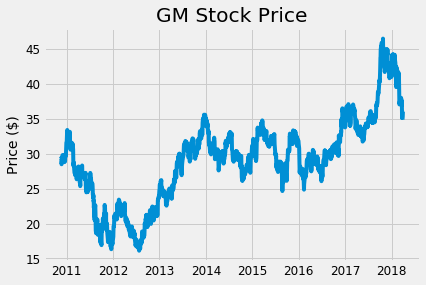

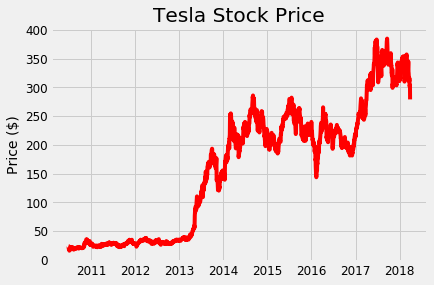

In [28]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

In [61]:
# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 
                2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}

gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 
                2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010: 1.50e9}

In [62]:
# Create a year column 
tesla['Year'] = tesla.Year

# Take Dates from index and move to Date column 
tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    
    # Update the cap column to shares times the price
    tesla.loc[i, 'cap'] = shares * tesla.loc[i, 'Adj. Close']

In [66]:
# Create a year column 
gm['Year'] = gm.Year

# Take Dates from index and move to Date column 
#gm.reset_index(level=0, inplace = True)
gm['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    
    # Update the cap column to shares times the price
    gm.loc[i, 'cap'] = shares * gm.loc[i, 'Adj. Close']

In [67]:
# Merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')
cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)

In [68]:
# Select only the relevant columns
cars = cars.loc[:, ['Date', 'gm_cap', 'tesla_cap']]

# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9

cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


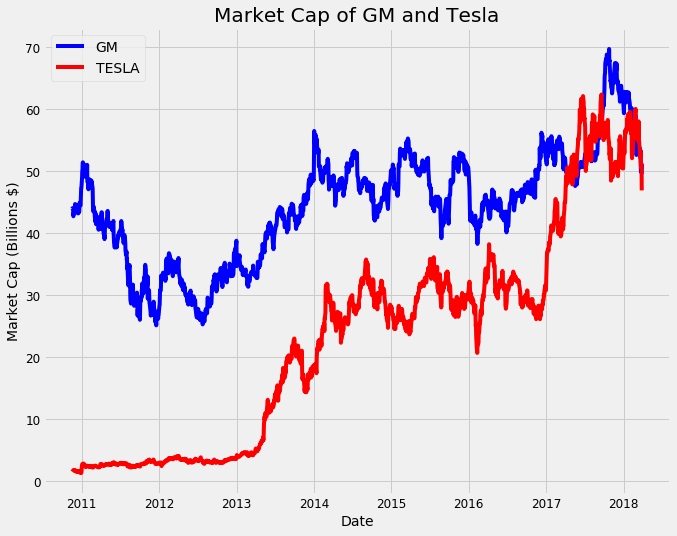

In [69]:
plt.figure(figsize=(10, 8))
plt.plot(cars['Date'], cars['gm_cap'], 'b-', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of GM and Tesla')
plt.legend();

In [70]:

import numpy as np

# Find the first and last time Tesla was valued higher than GM
first_date = cars.loc[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.loc[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']

print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23.


In [72]:
import fbprophet

# Prophet requires columns ds (Date) and y (value)
gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
gm['y'] = gm['y'] / 1e9

# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
gm_prophet.fit(gm)

# Repeat for the tesla data
tesla =tesla.rename(columns={'Date': 'ds', 'cap': 'y'})
tesla['y'] = tesla['y'] / 1e9
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, n_changepoints=10)
tesla_prophet.fit(tesla);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [73]:
# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

tesla_forecast = tesla_prophet.make_future_dataframe(periods=365*2, freq='D')
tesla_forecast = tesla_prophet.predict(tesla_forecast)


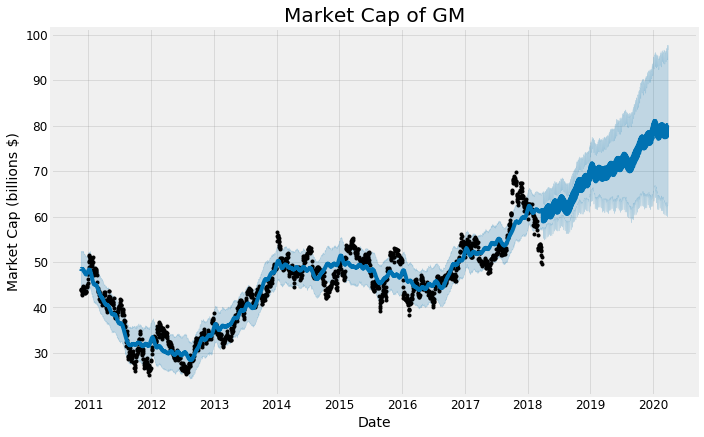

In [74]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GM');

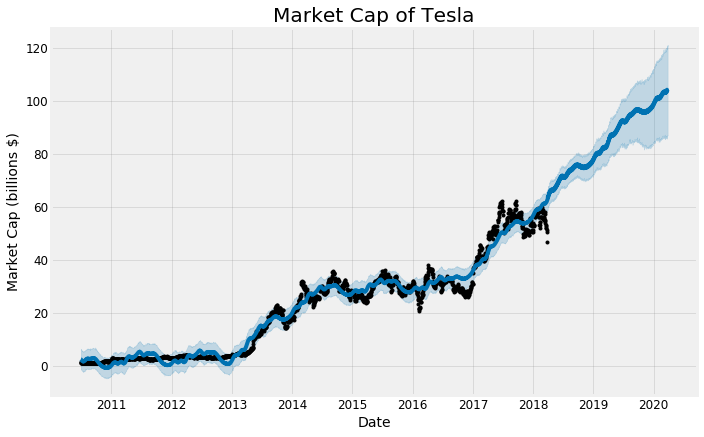

In [75]:
tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Tesla');

In [76]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(tesla)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    tesla[changepoint] = future['yhat']

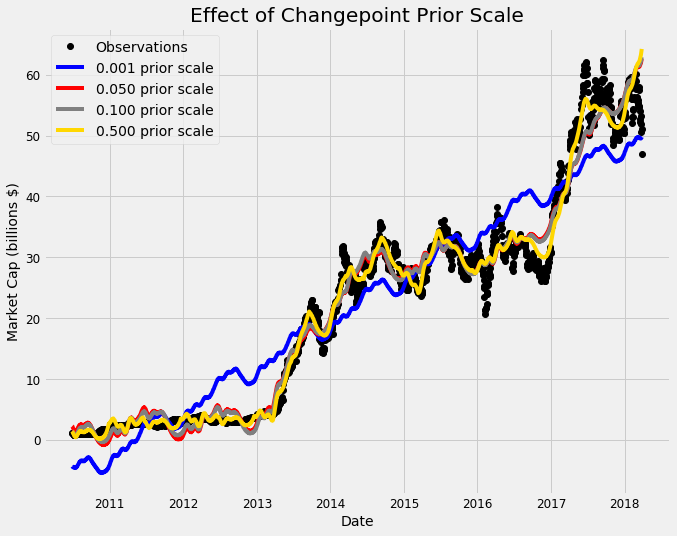

In [77]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(tesla['ds'], tesla['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(tesla['ds'], tesla[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale');

In [78]:
gm_prophet.changepoints[:10]

59    2011-02-14
118   2011-05-10
177   2011-08-03
236   2011-10-26
296   2012-01-24
355   2012-04-18
414   2012-07-12
473   2012-10-04
532   2013-01-02
591   2013-03-28
Name: ds, dtype: datetime64[ns]

In [79]:
tesla_prophet.changepoints[:10]

156    2011-02-09
312    2011-09-22
467    2012-05-04
623    2012-12-18
779    2013-08-02
935    2014-03-18
1091   2014-10-28
1246   2015-06-11
1402   2016-01-25
1558   2016-09-06
Name: ds, dtype: datetime64[ns]

ConversionError: Failed to convert value(s) to axis units: ['2011-02-09 00:00:00', '2011-09-22 00:00:00', '2012-05-04 00:00:00', '2012-12-18 00:00:00', '2013-08-02 00:00:00', '2014-03-18 00:00:00', '2014-10-28 00:00:00', '2015-06-11 00:00:00', '2016-01-25 00:00:00', '2016-09-06 00:00:00']

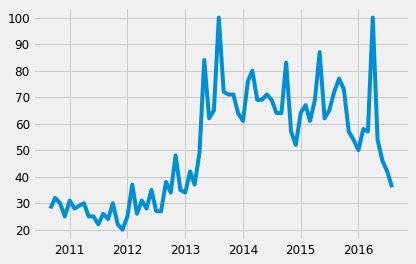

In [85]:
# Load in the data 
tesla_search = pd.read_csv('tesla_search_terms.txt')

# Convert month to a datetime
tesla_search['Month'] = pd.to_datetime(tesla_search['Month'])
tesla_changepoints = [str(date) for date in tesla_prophet.changepoints]

# Plot the search frequency
plt.plot(tesla_search['Month'], tesla_search['Search'], label = 'Searches')

# Plot the changepoints
plt.vlines(tesla_changepoints, ymin = 0, ymax= 100, colors = 'r', linewidth=0.6, linestyles = 'dashed', label = 'Changepoints')
plt.grid('off'); plt.ylabel('Relative Search Freq'); plt.legend()
plt.title('Tesla Search Terms and Changepoints');

In [87]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]

# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()

# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names

# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')

# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)
forecast.head()

,Date,gm_trend,gm_yhat_lower,gm_yhat_upper,gm_trend_lower,gm_trend_upper,gm_additive_terms,gm_additive_terms_lower,gm_additive_terms_upper,gm_weekly,...,tesla_weekly,tesla_weekly_lower,tesla_weekly_upper,tesla_yearly,tesla_yearly_lower,tesla_yearly_upper,tesla_multiplicative_terms,tesla_multiplicative_terms_lower,tesla_multiplicative_terms_upper,tesla_yhat
0,2010-11-18,47.143796,44.514871,52.456152,47.143796,47.143796,1.334752,1.334752,1.334752,0.734087,...,-0.192466,-0.192466,-0.192466,-2.284715,-2.284715,-2.284715,0.0,0.0,0.0,-0.693293
1,2010-11-19,47.102021,44.569732,52.458176,47.102021,47.102021,1.312172,1.312172,1.312172,0.674446,...,-0.221076,-0.221076,-0.221076,-2.318645,-2.318645,-2.318645,0.0,0.0,0.0,-0.745844
2,2010-11-22,46.976698,44.366823,52.216748,46.976698,46.976698,1.469148,1.469148,1.469148,0.696183,...,-0.137378,-0.137378,-0.137378,-2.409908,-2.409908,-2.409908,0.0,0.0,0.0,-0.723438
3,2010-11-23,46.934923,44.367347,52.421758,46.934923,46.934923,1.477682,1.477682,1.477682,0.656102,...,-0.171823,-0.171823,-0.171823,-2.436556,-2.436556,-2.436556,0.0,0.0,0.0,-0.774541
4,2010-11-24,46.893149,44.369344,52.493019,46.893149,46.893149,1.601959,1.601959,1.601959,0.732381,...,-0.128724,-0.128724,-0.128724,-2.461211,-2.461211,-2.461211,0.0,0.0,0.0,-0.746107


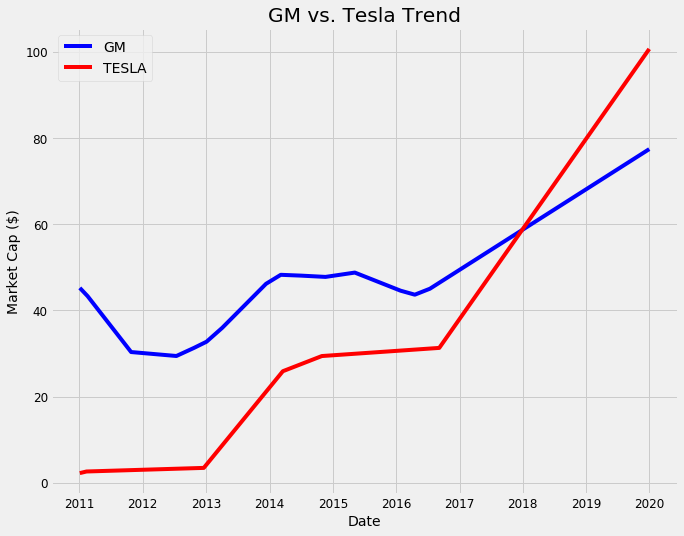

In [139]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_trend'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_trend'], 'r-')
plt.legend(['GM', 'TESLA']); plt.xlabel('Date'); plt.ylabel('Market Cap ($)')
plt.title('GM vs. Tesla Trend');

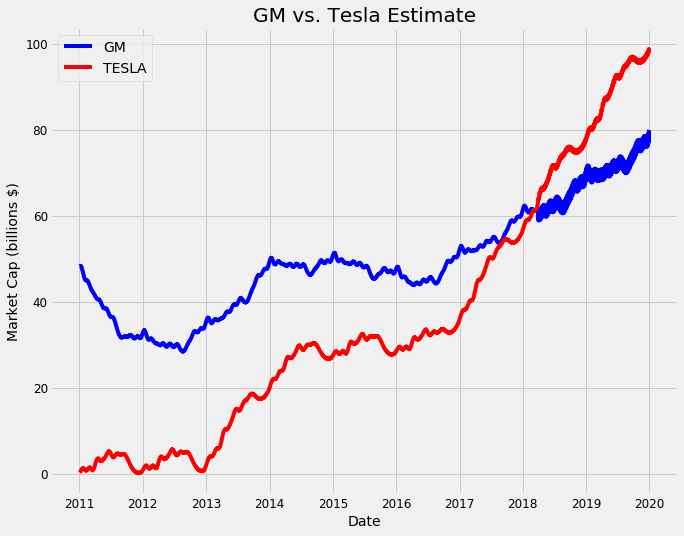

In [138]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_yhat'], 'r-')
plt.legend(['GM', 'TESLA']); plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)')
plt.title('GM vs. Tesla Estimate');

In [91]:
overtake_date = min(forecast.loc[forecast['tesla_yhat'] > forecast['gm_yhat'], 'Date'])
print('Tesla overtakes GM on {}'.format(overtake_date))

Tesla overtakes GM on 2018-03-05 00:00:00


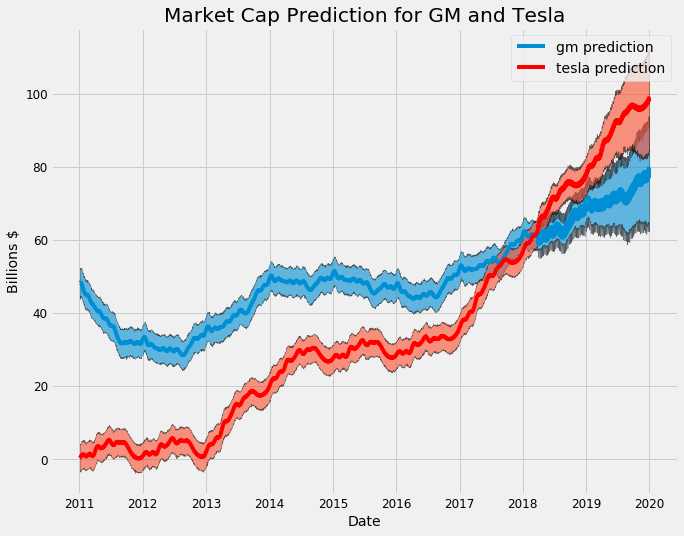

In [93]:
# Only keep years 2011 onwards and from before 2020
forecast = forecast[forecast['Date'] > '2010-12-31']
forecast = forecast[forecast['Date'] < '2020-01-01']
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 8));

# Plot estimate
ax.plot(forecast['Date'], forecast['gm_yhat'], label = 'gm prediction');

# Plot uncertainty values
ax.fill_between(forecast['Date'].dt.to_pydatetime(), forecast['gm_yhat_upper'], forecast['gm_yhat_lower'], alpha=0.6, edgecolor = 'k');

# Plot estimate and uncertainty for tesla
ax.plot(forecast['Date'], forecast['tesla_yhat'], 'r', label = 'tesla prediction');
ax.fill_between(forecast['Date'].dt.to_pydatetime(), forecast['tesla_yhat_upper'], forecast['tesla_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('Market Cap Prediction for GM and Tesla');

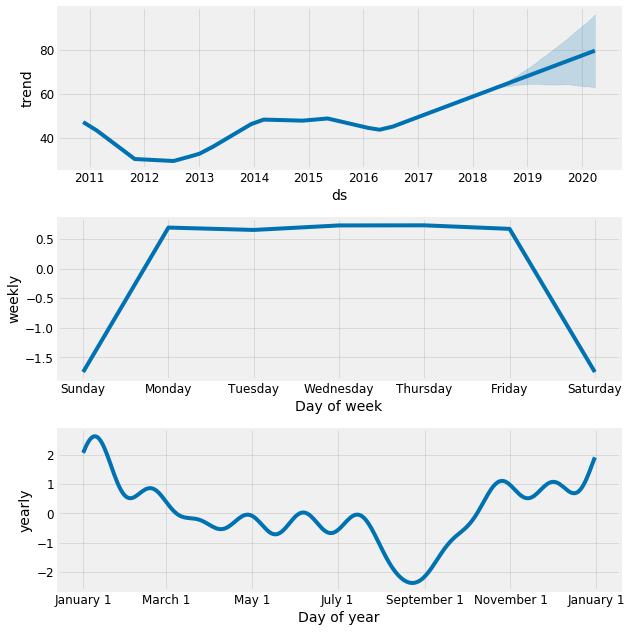

In [94]:
gm_prophet.plot_components(gm_forecast);

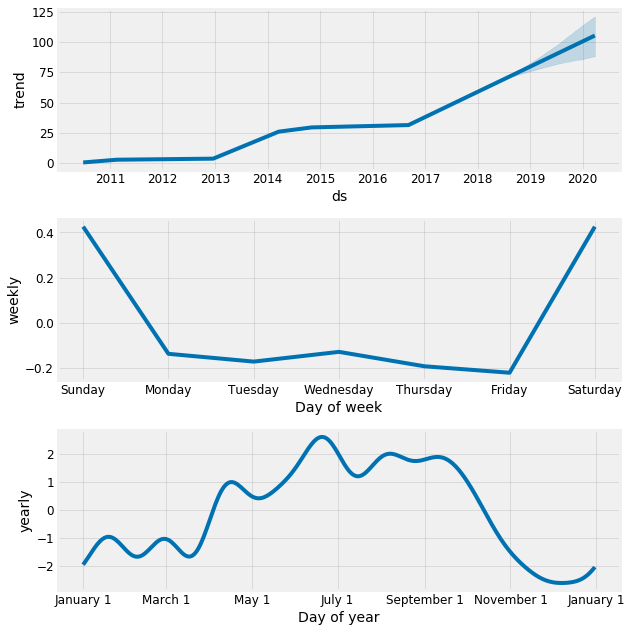

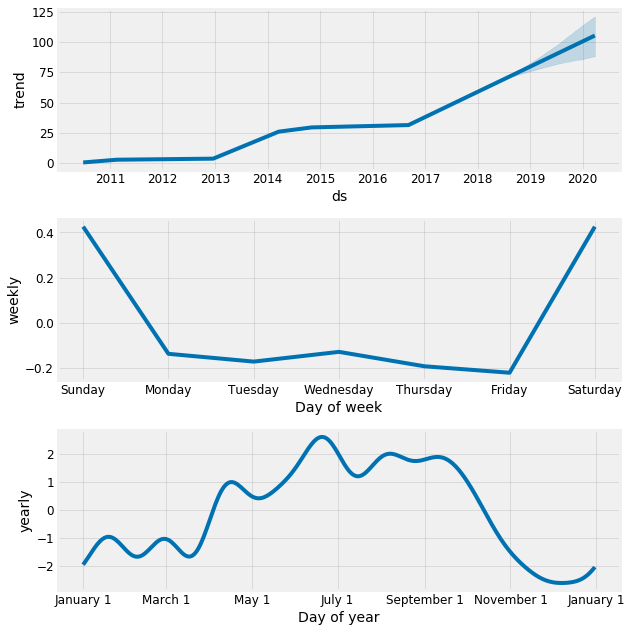

In [95]:
tesla_prophet.plot_components(tesla_forecast)

These graphs show that Tesla tends to increase during the summer, and decrease during the winter, while GM plummets during the summer and increases during the winter. We could compare GM sales with these graphs to see if there is any correlation.

In [97]:
# Read in the sales data
gm_sales = pd.read_csv('gm_sales.txt')
gm_sales.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
0,2017,195909,237388,256224,244406,237364,243151,226107,275552,279397,252813,245387,308539,3002237
1,2016,203745,227825,252128,259557,240449,255209,267258,256429,249795,258626,252644,319108,3042773
2,2015,202786,231378,249875,269055,293097,259346,272512,270480,251310,262993,229296,290230,3082358
3,2014,171486,222104,256047,254076,284694,267461,256160,272422,223437,226819,225818,274483,2935007
4,2013,194699,224314,245950,237646,252894,264843,234071,275847,187195,226402,212060,230157,2786078


In [98]:
# Melt the sales data and rename columns
gm_sales = gm_sales.melt(id_vars='Year', var_name = 'Month', value_name = 'Sales')
gm_sales.head(8)

,Year,Month,Sales
0,2017,Jan,195909
1,2016,Jan,203745
2,2015,Jan,202786
3,2014,Jan,171486
4,2013,Jan,194699
5,2012,Jan,167962
6,2011,Jan,178896
7,2010,Jan,145098


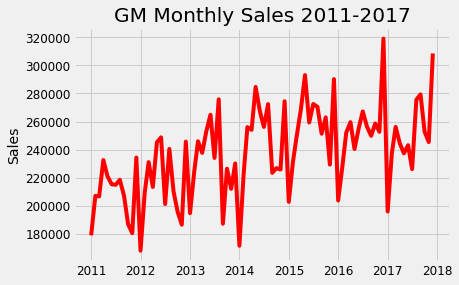

In [99]:
# Format the data for plotting
gm_sales = gm_sales[gm_sales['Month'] != 'Total']
gm_sales = gm_sales[gm_sales['Year'] > 2010]
gm_sales['Date'] = ['-'.join([str(year), month]) for year, month in zip(gm_sales['Year'], gm_sales['Month'])]
gm_sales['Date'] = pd.to_datetime(gm_sales['Date'], format = "%Y-%b")
gm_sales.sort_values(by = 'Date', inplace=True)
gm_sales['Month'] = [date.month for date in gm_sales['Date']]

# Plot the sales over the period
plt.plot(gm_sales['Date'], gm_sales['Sales'], 'r');
plt.title('GM Monthly Sales 2011-2017'); plt.ylabel('Sales');

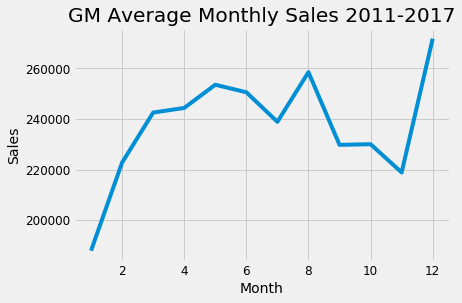

In [100]:
gm_sales_grouped = gm_sales.groupby('Month').mean()
plt.plot(list(range(1, 13)), gm_sales_grouped['Sales']);
plt.xlabel('Month'); plt.ylabel('Sales'); plt.title('GM Average Monthly Sales 2011-2017');

In [135]:
gm_prophet.plot_yearly(); plt.title('GM Yearly Component of Market Cap');

AttributeError: 'Prophet' object has no attribute 'plot_yearly'

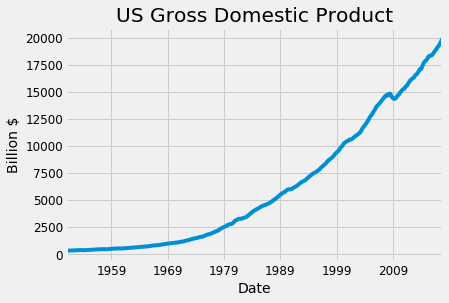

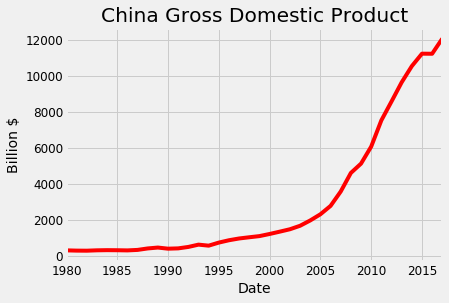

In [112]:
# Get data from quandl for US and China GDP
quandl.ApiConfig.api_key = 'oj1LwD9ryHKSYVXfvynN'

us_gdp = quandl.get('FRED/GDP', collapse='quarterly', start_date = '1950-12-31', end_date='2017-12-31')
china_gdp = quandl.get('ODA/CHN_NGDPD', collapse='yearly', start_date = '1950-12-31', end_date='2017-12-31')

pd.plotting.register_matplotlib_converters()

us_gdp.plot(title = 'US Gross Domestic Product', legend=None);
plt.ylabel('Billion $'); 
china_gdp.plot(title = 'China Gross Domestic Product', color = 'r', legend=None);
plt.ylabel('Billion $');

In [113]:
# Change index to date column
us_gdp = us_gdp.reset_index(level=0)
us_gdp.head(5)

,Date,Value
0,1951-03-31,336.000
1,1951-06-30,344.090
2,1951-09-30,351.385
3,1951-12-31,356.178
4,1952-03-31,359.820


In [114]:
china_gdp = china_gdp.reset_index(level=0)
china_gdp.head(5)

,Date,Value
0,1980-12-31,305.348
1,1981-12-31,290.827
2,1982-12-31,286.719
3,1983-12-31,307.677
4,1984-12-31,316.628


In [115]:
# Merge the two gdp data frames and rename columns
gdp = us_gdp.merge(china_gdp, on = 'Date', how = 'left').rename(columns={'Value_x': 'US', 'Value_y': 'China'})
gdp.head(5)

,Date,US,China
0,1951-03-31,336.000,NaN
1,1951-06-30,344.090,NaN
2,1951-09-30,351.385,NaN
3,1951-12-31,356.178,NaN
4,1952-03-31,359.820,NaN


In [116]:
round(gdp.describe(), 2)

,US,China
count,268.00,38.00
mean,6108.51,2984.68
std,5873.70,3755.50
min,336.00,286.72
25%,877.39,412.84
50%,4046.93,1064.86
75%,10503.73,4346.08
max,19918.91,12062.28


In [117]:
# Fill in missing China observations using backward fill
gdp = gdp.fillna(method='bfill')

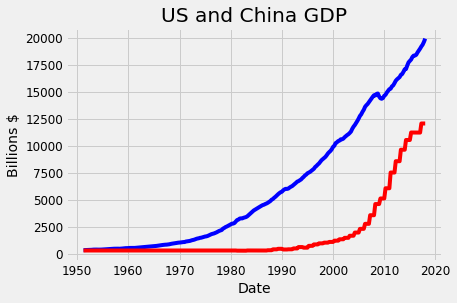

In [119]:
plt.plot(gdp['Date'], gdp['US'], label = 'US', color =  'b')
plt.plot(gdp['Date'], gdp['China'], label = 'China', color = 'r')
plt.ylabel('Billions $'); plt.title('US and China GDP'); plt.xlabel('Date');

In [120]:
# Create a prophet object for each dataframe
us_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)
china_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)

# Prophet needs dataframes with a ds (date) and y (variable) column
# Use pandas rename functionality (format is dictionary with {'old': 'new'})
us_gdp = us_gdp.rename(columns={'Date': 'ds', 'Value': 'y'})
china_gdp = china_gdp.rename(columns={'Date': 'ds', 'Value': 'y'})

In [121]:
us_prophet.fit(us_gdp);
china_prophet.fit(china_gdp);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [122]:
us_prophet.changepoints

9     1953-06-30
17    1955-06-30
26    1957-09-30
34    1959-09-30
43    1961-12-31
51    1963-12-31
60    1966-03-31
68    1968-03-31
77    1970-06-30
85    1972-06-30
94    1974-09-30
102   1976-09-30
111   1978-12-31
119   1980-12-31
128   1983-03-31
136   1985-03-31
145   1987-06-30
153   1989-06-30
162   1991-09-30
170   1993-09-30
179   1995-12-31
187   1997-12-31
196   2000-03-31
204   2002-03-31
213   2004-06-30
Name: ds, dtype: datetime64[ns]

In [123]:
recessions = pd.read_csv('recessions.txt', encoding='latin')

In [124]:
recessions[6:]

,name,time,duration,max_unemp,gdp_decline
6,Recession of 196061,Apr 1960  Feb 1961,10 months,7%,2%
7,Recession of 196970,Dec 1969 Nov 1970,11 months,6%,1%
8,197375 recession,Nov 1973  Mar 1975,1 year 4 months,9%,3%
9,1980 recession,JanJuly 1980,6 months,8%,2%
10,19811982 recession,July 1981  Nov 1982,1 year 4 months,11%,3%
11,Early 1990s recession,July 1990  Mar 1991,8 months,8%,1%
12,Early 2000s recession,Mar 2001Nov 2001,8 months,6%,0%
13,Great Recession,Dec 2007  June 2009,1 year 6 months,10%,5%


In [125]:
# Make a future dataframe with 50 years of observations 
# US dataframe and predictions
us_forecast = us_prophet.make_future_dataframe(periods = 50, freq = 'Y')
us_forecast = us_prophet.predict(us_forecast)

# China dataframe and predictions
china_forecast = china_prophet.make_future_dataframe(periods = 50, freq = 'Y')
china_forecast = china_prophet.predict(china_forecast)

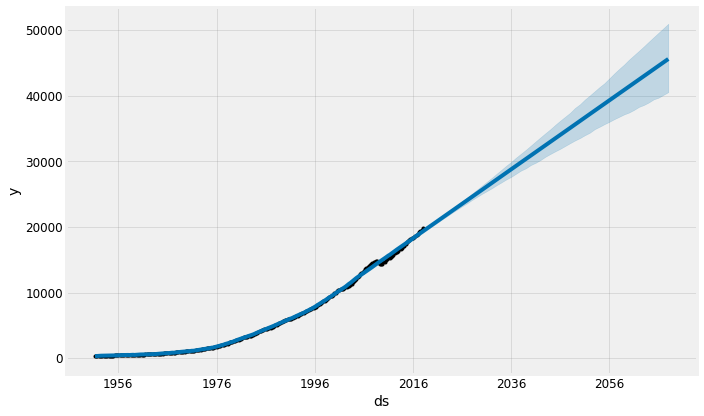

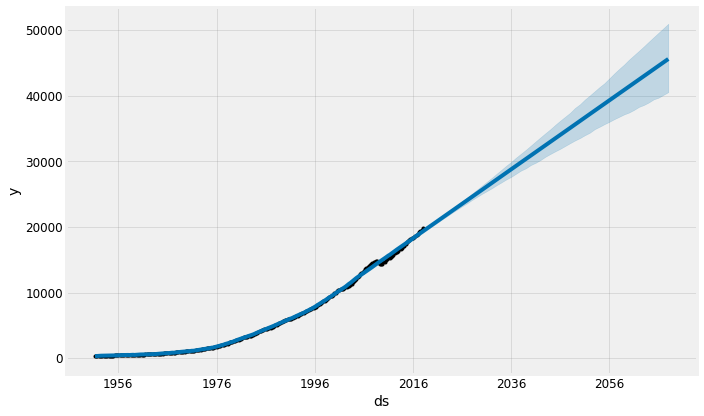

In [126]:
us_prophet.plot(us_forecast)

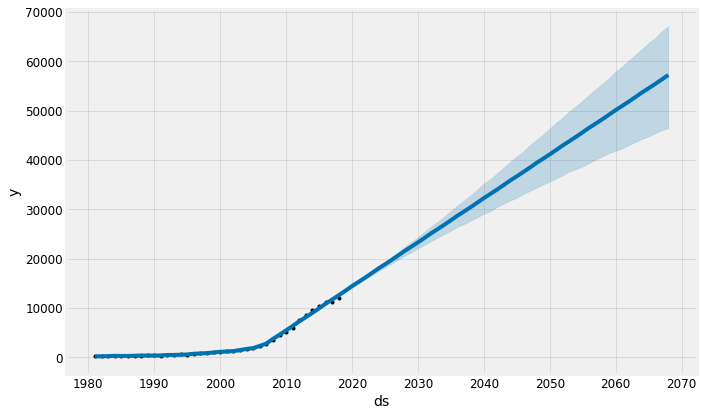

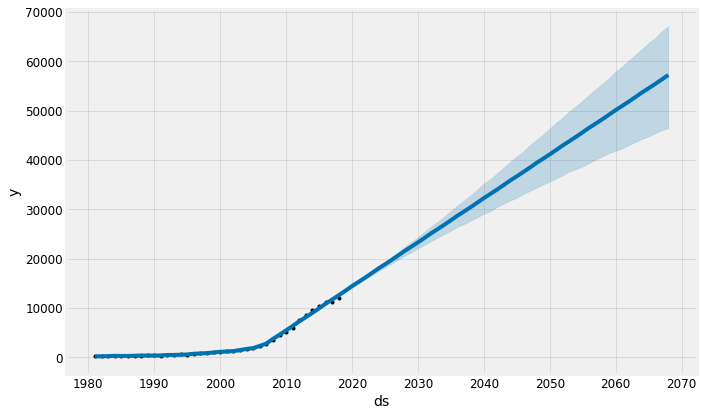

In [127]:
china_prophet.plot(china_forecast)

In [130]:
us_names = ['us_%s' % column for column in us_forecast.columns]
china_names = ['china_%s' % column for column in china_forecast.columns]

# Dataframes to merge
merge_us_forecast = us_forecast.copy()
merge_china_forecast = china_forecast.copy()

# Rename the columns
merge_us_forecast.columns = us_names
merge_china_forecast.columns = china_names

In [131]:
# Merge the two datasets
gdp_forecast = pd.merge(merge_us_forecast, merge_china_forecast, how = 'inner', left_on = 'us_ds', right_on = 'china_ds')

# Rename date column
gdp_forecast = gdp_forecast.rename(columns={'us_ds': 'Date'}).drop('china_ds', axis=1)
gdp_forecast.head()

,Date,us_trend,us_yhat_lower,us_yhat_upper,us_trend_lower,us_trend_upper,us_additive_terms,us_additive_terms_lower,us_additive_terms_upper,us_yearly,...,china_additive_terms,china_additive_terms_lower,china_additive_terms_upper,china_yearly,china_yearly_lower,china_yearly_upper,china_multiplicative_terms,china_multiplicative_terms_lower,china_multiplicative_terms_upper,china_yhat
0,1980-12-31,3359.787751,2759.909865,3197.373761,3359.787751,3359.787751,-380.360097,-380.360097,-380.360097,-380.360097,...,-1109.548511,-1109.548511,-1109.548511,-1109.548511,-1109.548511,-1109.548511,0.0,0.0,0.0,240.200573
1,1981-12-31,3623.042191,3021.067656,3456.680419,3623.042191,3623.042191,-382.349108,-382.349108,-382.349108,-382.349108,...,-1124.805925,-1124.805925,-1124.805925,-1124.805925,-1124.805925,-1124.805925,0.0,0.0,0.0,242.949634
2,1982-12-31,3886.296630,3286.119788,3718.890904,3886.296630,3886.296630,-383.895567,-383.895567,-383.895567,-383.895567,...,-1111.435652,-1111.435652,-1111.435652,-1111.435652,-1111.435652,-1111.435652,0.0,0.0,0.0,274.326379
3,1983-12-31,4184.160302,3604.189742,4019.890337,4184.160302,4184.160302,-384.996463,-384.996463,-384.996463,-384.996463,...,-1069.470637,-1069.470637,-1069.470637,-1069.470637,-1069.470637,-1069.470637,0.0,0.0,0.0,334.297868
4,1984-12-31,4494.197730,3897.189804,4336.601806,4494.197730,4494.197730,-380.360097,-380.360097,-380.360097,-380.360097,...,-1109.548511,-1109.548511,-1109.548511,-1109.548511,-1109.548511,-1109.548511,0.0,0.0,0.0,312.275801


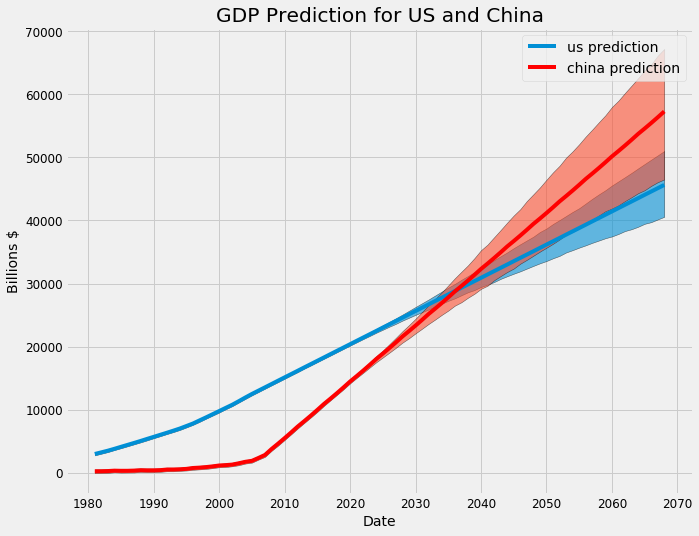

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8));
ax.plot(gdp_forecast['Date'], gdp_forecast['us_yhat'], label = 'us prediction');
ax.fill_between(gdp_forecast['Date'].dt.to_pydatetime(), gdp_forecast['us_yhat_upper'], gdp_forecast['us_yhat_lower'], alpha=0.6, edgecolor = 'k');
ax.plot(gdp_forecast['Date'], gdp_forecast['china_yhat'], 'r', label = 'china prediction');
ax.fill_between(gdp_forecast['Date'].dt.to_pydatetime(), gdp_forecast['china_yhat_upper'], gdp_forecast['china_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('GDP Prediction for US and China');

In [134]:
first_pass = min(gdp_forecast.loc[gdp_forecast['us_yhat'] < gdp_forecast['china_yhat'], 'Date'])
print('China will overtake the US in GDP on {}.'.format(first_pass))

China will overtake the US in GDP on 2036-12-31 00:00:00.
